In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

In [3]:
train_data = torchvision.datasets.CIFAR10('/Users/aniket/datasets/',
                                          download=True,
                                          transform=transform)

val_data = torchvision.datasets.CIFAR10('/Users/aniket/datasets/',
                                        train=False,
                                        download=True,
                                        transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data,
                                        batch_size=batch_size,
                                        shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

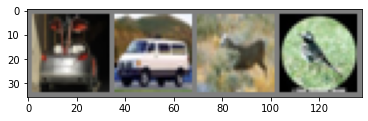

  car   car  deer  bird


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
NUM_EPOCHS = 2

In [9]:
# Calculate loss
def train_step(model, data):
    inputs, labels = data

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    return loss

In [43]:
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # zero the parameter gradients
        optimizer.zero_grad()
        
        loss = train_step(net, data)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

# ⚡️ PyTorch Lightning 

## Lightning Design Philosophy

![Design Phil](https://camo.githubusercontent.com/a3dda9b3053f7093ac1ccc30b41c0f367b171010770252528c30551a2407cad5/68747470733a2f2f706c2d626f6c74732d646f632d696d616765732e73332e75732d656173742d322e616d617a6f6e6177732e636f6d2f7068696c6f736f70686965732e6a7067)

In [10]:
import pytorch_lightning as pl

/Users/aniket/miniconda3/envs/am/lib/python3.7/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


In [41]:
class LitModel(pl.LightningModule):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = Net()
    
    
    def forward(self, x):
        return self.model(x)
    
    
    def training_step(self, batch, batch_idx):
        loss = train_step(self, batch)
        self.log('train_loss', loss)
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        loss = train_step(self, batch)
        self.log('val_loss', loss)
        return loss
    
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams['lr'])
        return optimizer
    
    

In [42]:
lit_model = LitModel(1e-3)
trainer = pl.Trainer()
trainer.fit(lit_model, trainloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Tensorboard